In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

dsb_data_dir = os.path.join('.', 'input')
stage_label = 'stage1'

#### Read in labels:
Load RLE-encoded output for the training set

In [201]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])

#### Load all images: 

In [ ]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)

#### Create training data:

In [ ]:
# %%time
train_df = img_df.query('TrainingSplit=="train"')

train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols): 
    # n_group: stage and imageId
    # n_rows: a list of rows that belong to the same stage and imageId
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)} # 'stage': 1, 'ID': 'XXX'
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist() # a list of path
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist() # original image path
    train_rows += [c_row]
# print(train_rows[0])
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

In [126]:
c_img = './input/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png'
# imread(c_img)
np.sum(np.stack([imread(c_img)], 0), 0).shape

(256, 256, 4)

In [122]:
train_img_df['images'][0].shape

(256, 256, 3)

Figure(1080x288)


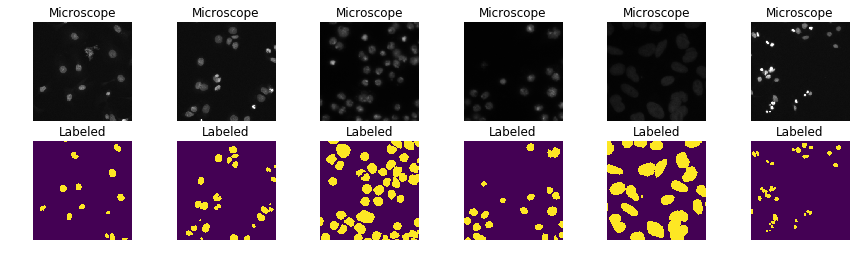

In [113]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (15, 4))
print(m_axs[0])
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

#### Intensity Distribution

In [118]:
train_img_df['images'][0].shape


(256, 256, 3)

#### Check Dimension

In [132]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

#### Make a simple CNN

In [133]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS), 
                                  name = 'NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
# use dilations to get a slightly larger field of view
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

# the final processing
simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
simple_cnn.summary()

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 16)    528       
__________

#### Loss

In [134]:
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
simple_cnn.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])

#### Simple training
Run a simple training, with each image being it's own batch (not a very good idea), but it keeps the code simple

In [137]:
train_img_df.sample(1)

,ImageId,Stage,images,masks,Red,Green,Blue,Gray,Red-Blue
589,e23e11414ee645b51081fb202d38b793f0c8ef2940f822...,stage1,"[[[0.2, 0.2, 0.2], [0.18823529411764706, 0.188...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.09731,0.09731,0.09731,0.09731,0.0


In [160]:
# train_img_df.shape
# type(train_img_df)
# train_img_df['images'][0].shape
# train_img_df['masks'][0].shape
# np.expand_dims(train_img_df['images'][0], 0).shape
np.expand_dims(train_img_df['masks'][0], -1).shape

(256, 256, 1)

In [161]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)

simple_cnn.fit_generator(simple_gen(), 
                         steps_per_epoch=train_img_df.shape[0],
                        epochs = 3)

Epoch 1/3
670/670 [==============================] - 31s 46ms/step - loss: -0.7350 - dice_coef: 0.7350 - acc: 0.9010 - mean_squared_error: 0.0912
Epoch 2/3
670/670 [==============================] - 27s 40ms/step - loss: -0.7954 - dice_coef: 0.7954 - acc: 0.9271 - mean_squared_error: 0.0704
Epoch 3/3
670/670 [==============================] - 27s 40ms/step - loss: -0.8018 - dice_coef: 0.8018 - acc: 0.9297 - mean_squared_error: 0.0687


#### Apply model to test

In [169]:
# %%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
#     n_group: ('stage1', '0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5')
#     n_rows: path, ImageId, ImgaeType, TrainingSplit. Stage
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

(65, 'images to process')


,ImageId,Stage,images
28,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,stage1,"[[[0.01568627450980392, 0.01568627450980392, 0..."


In [171]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

CPU times: user 384 ms, sys: 112 ms, total: 496 ms
Wall time: 437 ms


#### Show a few predictions

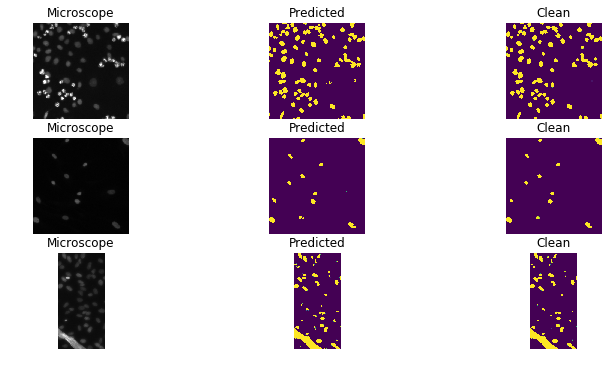

In [172]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

#### Checl RLE
Check our approach for RLE encoding works

In [173]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5): # encode for each connected region
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

#### Calculate the RLEs for a Train Image

In [175]:
train_img_df.tail(5)

,ImageId,Stage,images,masks,Red,Green,Blue,Gray,Red-Blue
665,fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...,stage1,"[[[0.043137254901960784, 0.043137254901960784,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.062943,0.062943,0.062943,0.062943,0.0
666,feffce59a1a3eb0a6a05992bb7423c39c7d52865846da3...,stage1,"[[[0.050980392156862744, 0.050980392156862744,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.076287,0.076287,0.076287,0.076287,0.0
667,ff3407842ada5bc18be79ae453e5bdaa1b68afc842fc22...,stage1,"[[[0.047058823529411764, 0.047058823529411764,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.067886,0.067886,0.067886,0.067886,0.0
668,ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0b...,stage1,"[[[0.00784313725490196, 0.00784313725490196, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.015258,0.015258,0.015258,0.015258,0.0
669,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,stage1,"[[[0.0196078431372549, 0.0196078431372549, 0.0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.047566,0.047566,0.047566,0.047566,0.0


In [174]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

In [180]:
np.where(train_rle_row['masks'].T.flatten() == 1)

(array([  869,   870,   871, ..., 49379, 49380, 49381]),)

#### Take the RLEs from the CSV

In [205]:
train_labels.sample(2)

,ImageId,EncodedPixels
835,07fb37aafa6626608af90c1e18f6a743f29b6b233d2e42...,"[191774, 9, 192293, 11, 192812, 13, 193331, 14..."
423,0402a81e75262469925ea893b6706183832e85324f7b1e...,"[29884, 9, 30143, 11, 30403, 12, 30662, 13, 30..."


In [206]:
train_rle_row

ImageId     fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...
Stage                                                  stage1
images      [[[0.043137254901960784, 0.043137254901960784,...
masks       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Red                                                 0.0629432
Green                                               0.0629432
Blue                                                0.0629432
Gray                                                0.0629432
Red-Blue                                                    0
Name: 665, dtype: object

In [207]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']
tl_rles

29354    [7853, 6, 8108, 8, 8364, 9, 8620, 9, 8876, 9, ...
29355    [38270, 2, 38525, 4, 38779, 8, 39034, 14, 3929...
29356    [9632, 4, 9887, 7, 10142, 8, 10398, 9, 10653, ...
29357    [32190, 3, 32445, 6, 32700, 10, 32956, 12, 332...
29358    [11879, 4, 12133, 9, 12388, 11, 12643, 12, 128...
29359    [12027, 3, 12282, 5, 12538, 5, 12793, 6, 13049...
29360    [15691, 1, 15945, 4, 16201, 7, 16456, 8, 16711...
29361    [25125, 10, 25380, 12, 25635, 13, 25891, 14, 2...
29362    [32998, 5, 33252, 8, 33507, 10, 33763, 10, 340...
29363    [22462, 2, 22717, 5, 22972, 7, 23227, 9, 23483...
29364    [11561, 4, 11815, 9, 12070, 12, 12326, 14, 125...
29365    [870, 7, 1124, 9, 1380, 10, 1635, 11, 1891, 11...
29366    [44773, 2, 45026, 8, 45280, 11, 45534, 13, 457...
Name: EncodedPixels, dtype: object

#### Check

In [208]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

Matches: 360, Mismatches: 0, Accuracy: 100.0%


#### Calculate RLE for all the masks

In [209]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [210]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

(1731, 'regions found for', 65, 'images')


,EncodedPixels,ImageId
1126,25135 3 25389 7 25644 9 25899 10 26155 11 2641...,912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea...
565,38775 5 39031 11 39289 14 39548 15 39808 16 40...,52b267e20519174e3ce1e1994b5d677804b16bc670aa5f...
1721,30418 3 30672 7 30927 10 31182 12 31438 12 316...,fe9adb627a6f45747c5a8223b671774791ededf9364f65...


In [211]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)